In [56]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
df = pd.read_csv('data_co2.csv', names=['Year', 'PPM'], skiprows=1)

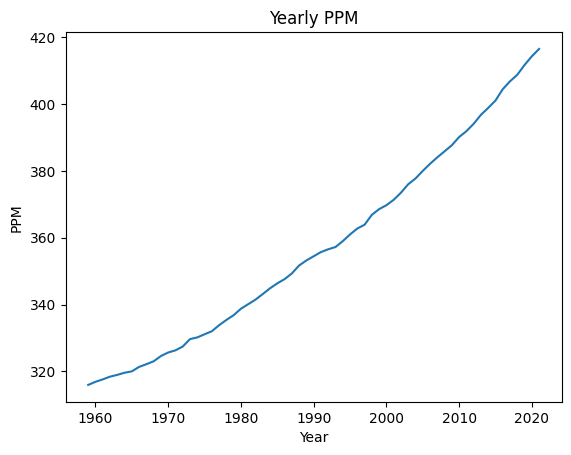

In [58]:
plt.plot(df['Year'], df['PPM'])
plt.xlabel('Year')
plt.ylabel('PPM')
plt.title('Yearly PPM')
plt.show()

In [59]:
years = df['Year']
ppm = df['PPM']

In [60]:
SPLIT_TIME = int(0.8 * len(df))  # on day 80% the training period will end. The rest will belong to the validation set
WINDOW_SIZE = 10  # how many data points will we take into account to make our prediction
BATCH_SIZE = 32  # how many items will we supply per batch
SHUFFLE_BUFFER_SIZE = 1000  # we need this parameter to define the Tensorflow sample buffer

In [61]:
def new_train_val_split(series, time_step=SPLIT_TIME):
    """Divide the time series into training and validation set"""
    series_train = series[:time_step]
    series_valid = series[time_step:]

    return series_train, series_valid


def train_val_split(time, series, time_step=SPLIT_TIME):
    """Divide the time series into training and validation set"""
    time_train = time[:time_step]
    series_train = series[:time_step]
    time_valid = time[time_step:]
    series_valid = series[time_step:]

    return time_train, series_train, time_valid, series_valid


def windowed_dataset(series, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER_SIZE):
    """
    We create time windows to create X and y features.
    For example, if we choose a window of 30, we will create a dataset formed by 30 points as X
    """
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [62]:
def normalize(data, mean, std):
    return (data - mean) / std

In [63]:
def unnormalize(data, mean, std):
    return data * std + mean

In [64]:
# we divide into training and validation set
time_train, series_train, time_valid, series_valid = train_val_split(years, ppm)

In [65]:
series_train_mean = series_train.mean()
series_train_std = series_train.std()

In [66]:
ppm_normed = normalize(ppm, series_train_mean, series_train_std)

In [67]:
series_train_normed, series_valid_normed = new_train_val_split(ppm_normed)

In [68]:
# series_train_normed = normalize(series_train, series_train_mean, series_train_std)
# series_valid_normed = normalize(series_valid, series_train_mean, series_train_std)

# let's create the dataset with time windows
train_dataset = windowed_dataset(series_train_normed)
valid_dataset = windowed_dataset(series_valid_normed)

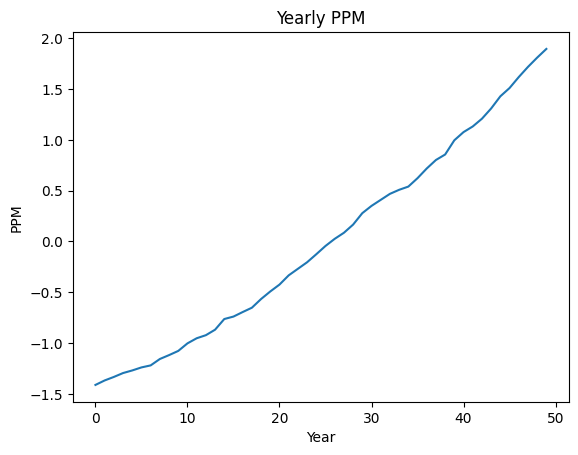

In [69]:
plt.plot(series_train_normed)
plt.xlabel('Year')
plt.ylabel('PPM')
plt.title('Yearly PPM')
plt.show()

In [70]:
def create_uncompiled_model():
    # define a sequential model
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                               input_shape=[None]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(1024, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(1),
    ])

    return model

In [71]:
class EarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('mse') < 0.001):
            print("\nMSE threshold reached. Training stopped.")
            self.model.stop_training = True


# Let's create an object of our class and assign it to a variable
early_stopping = EarlyStopping()

In [72]:
def create_model():
    tf.random.set_seed(51)

    model = create_uncompiled_model()

    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=["mse"])
    return model


model = create_model()

# we train for 20 epochs with and assign the callback
history = model.fit(train_dataset, epochs=20, validation_data=valid_dataset, callbacks=[early_stopping])

Epoch 1/20
2/2 [==============================] - 27s 5s/step - loss: 0.3208 - mse: 0.7153 - val_loss: 0.0352 - val_mse: 0.0703
Epoch 2/20
2/2 [==============================] - 2s 1s/step - loss: 0.6159 - mse: 1.3557 - val_loss: 1.6417 - val_mse: 4.5920
Epoch 3/20
2/2 [==============================] - 2s 978ms/step - loss: 0.1733 - mse: 0.3475 - val_loss: 1.3609 - val_mse: 3.4683
Epoch 4/20
2/2 [==============================] - 2s 932ms/step - loss: 0.1064 - mse: 0.2129 - val_loss: 0.5865 - val_mse: 1.1878
Epoch 5/20
2/2 [==============================] - 2s 908ms/step - loss: 0.0370 - mse: 0.0741 - val_loss: 0.9898 - val_mse: 2.2287
Epoch 6/20
2/2 [==============================] - 2s 962ms/step - loss: 0.0282 - mse: 0.0563 - val_loss: 1.5539 - val_mse: 4.2281
Epoch 7/20
2/2 [==============================] - 2s 954ms/step - loss: 0.0299 - mse: 0.0599 - val_loss: 1.3708 - val_mse: 3.5083
Epoch 8/20
2/2 [==============================] - 2s 929ms/step - loss: 0.0218 - mse: 0.0437 - 

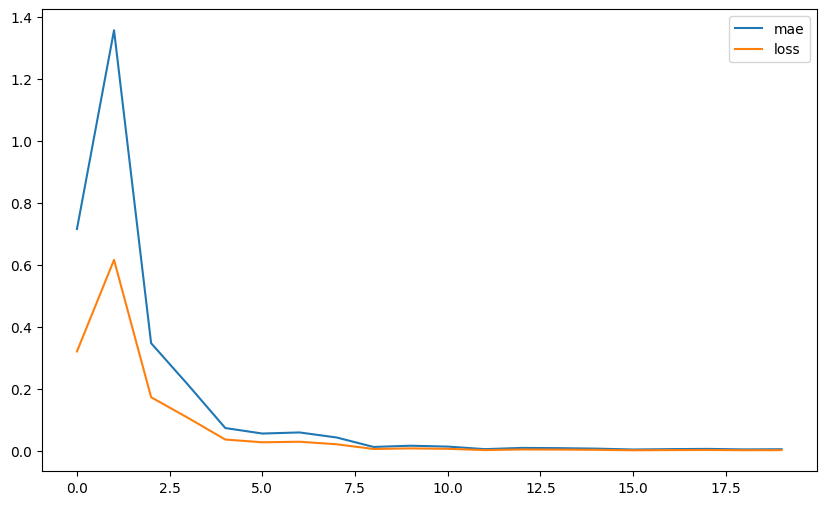

In [73]:
# plot MAE and loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['mse'], label='mae')
plt.plot(history.history['loss'], label='loss')
plt.legend()
plt.show()

In [74]:
preds = model.predict(valid_dataset)
preds[0]

1/1 [==============================] - 4s 4s/step


array([2.6319427], dtype=float32)

In [75]:
preds_unnormed = unnormalize(preds, series_train_mean, series_train_std)
preds_unnormed[0]

array([401.42297], dtype=float32)

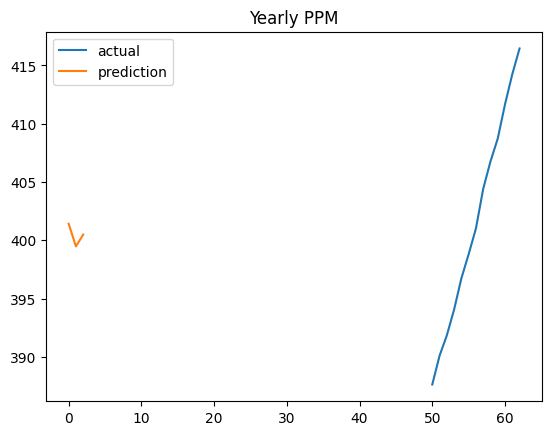

In [76]:
plt.plot(unnormalize(series_valid_normed, series_train_mean, series_train_std),
         label='actual')  # our val was taken as subset of the normaized data, so we need to unnormalize it here
plt.plot(preds_unnormed[:, 0], label='prediction')
plt.legend()
plt.title('Yearly PPM')
plt.show()

In [77]:
def compute_metrics(true_series, forecast):
    """Helper to print MSE and MAE"""
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()

    return mse, mae


def model_forecast(model, series, window_size):
    """This function converts the input series into a dataset with time windows for forecasting"""
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [78]:
# Prediction on the whole series
all_forecast = model_forecast(model, series_valid_normed + series_valid_normed, WINDOW_SIZE).squeeze()

# Validation portion
val_forecast = all_forecast[SPLIT_TIME - WINDOW_SIZE:-1]






1/1 [==============================] - 5s 5s/step


In [79]:
val_forecast

array([], dtype=float32)

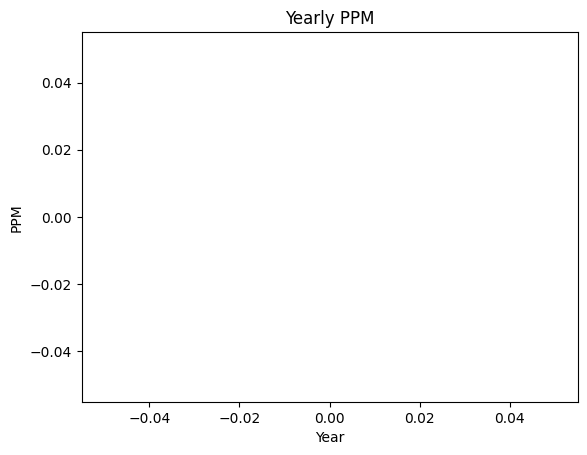

In [80]:
plt.plot(val_forecast)
plt.xlabel('Year')
plt.ylabel('PPM')
plt.title('Yearly PPM')
plt.show()

In [81]:
val_forecast = unnormalize(val_forecast, series_train_mean, series_train_std)

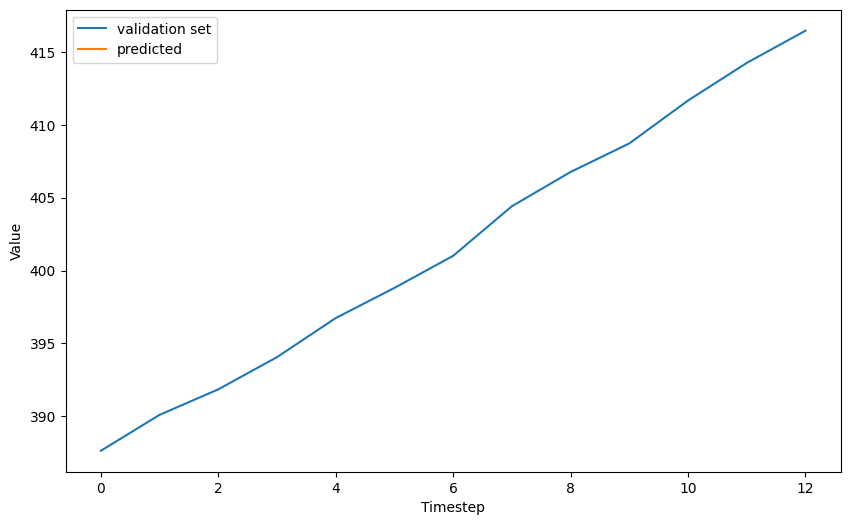

In [82]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(list(series_valid), label="validation set")
plt.plot(val_forecast, label="predicted")
plt.xlabel("Timestep")
plt.ylabel("Value")
plt.legend()
plt.show()

In [83]:
val_forecast

array([], dtype=float32)